In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import matplotlib.dates as mdates



df_items = pd.read_csv('olist_order_items_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')




In [14]:
df = pd.merge(df_items, df_products[['product_id', 'product_category_name']], on='product_id', how='left')

df = pd.merge(df, df_orders[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')

df = df.rename(columns={
              'product_category_name': 'item',
              'price': 'sells'})



In [15]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

df['date_only'] = df['order_purchase_timestamp'].dt.date



In [16]:
df['cleaned itens'] = df['item'].str.lower().str.strip()
df['sells'] = df['sells'].fillna(0)

print("Primeras linhas do dataset real processado:")
print(df[['date_only', 'cleaned itens', 'sells']].head())

Primeras linhas do dataset real processado:
    date_only       cleaned itens   sells
0  2017-09-13          cool_stuff   58.90
1  2017-04-26            pet_shop  239.90
2  2018-01-14    moveis_decoracao  199.00
3  2018-08-08          perfumaria   12.99
4  2017-02-04  ferramentas_jardim  199.90


In [17]:
df_category = df[df['item'] == 'cool_stuff']

df_sales_day = df_category.groupby('date_only')['sells'].sum().reset_index()



#Decidi usar n_dia para melhor vizualização de código

#df_sales_day['ordinal_date'] = df_sales_day['date_only'].apply(lambda x: x.toordinal())

#X = df_sales_day['ordinal_date'].values.reshape(-1, 1)

df_sales_day['n_dia'] = range(1, len(df_sales_day) + 1)
days = df_sales_day['n_dia'].values.reshape(-1, 1)
sales = df_sales_day['sells'].values


In [35]:
model = LinearRegression()
model.fit(days, sales)


last_day = int(days.max())

dias_futuros = np.array(range(last_day + 1, last_day + 31)).reshape(-1, 1)

linear_pred = model.predict(days)

previsao_futura = model.predict(dias_futuros)

print(f"Previsão de faturamento para daqui a 30 dias: $ {previsao_futura[-1]:.2f}")

Previsão de faturamento para daqui a 30 dias: $ 37492.27


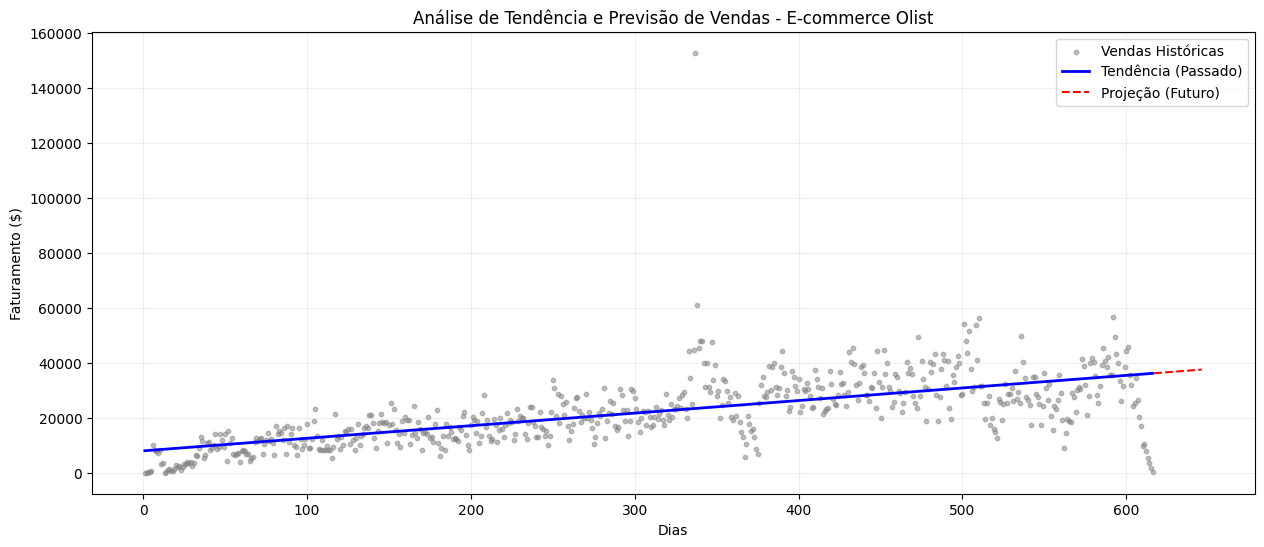

In [36]:

plt.figure(figsize=(15, 6))

# 1. Pontos cinzas: O que realmente aconteceu (616 pontos)
plt.scatter(days, sales, color='gray', alpha=0.5, label='Vendas Históricas', s=10)

# 2. Linha Azul: O que o modelo "entendeu" do passado (616 pontos)
# Aqui usamos o linear_pred que você calculou no treino
plt.plot(days, linear_pred, color='blue', label='Tendência (Passado)', linewidth=2)

# 3. Linha Vermelha: O que o modelo "prevê" para o futuro (30 pontos)
# Aqui usamos o dias_futuros (30) com a previsao_futura (30)
plt.plot(dias_futuros, previsao_futura, color='red', linestyle='--', label='Projeção (Futuro)')

plt.title('Análise de Tendência e Previsão de Vendas - E-commerce Olist')
plt.xlabel('Dias')
plt.ylabel('Faturamento ($)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [37]:
from sklearn.metrics import r2_score

# O R2 diz quanto da variação das vendas a sua linha explica (0 a 100%)
score = r2_score(sales, linear_pred)
print(f"Acurácia do Modelo (R²): {score:.2f}")

Acurácia do Modelo (R²): 0.42


In [38]:
poly = PolynomialFeatures(degree=2)
days_poly = poly.fit_transform(days)

poly_model = LinearRegression()
poly_model.fit(days_poly, sales)

poly_pred = poly_model.predict(days_poly)
new_score = r2_score(sales, poly_pred)

print(f"Novo R² com Regressão Polinomial: {new_score:.2f}")

Novo R² com Regressão Polinomial: 0.47


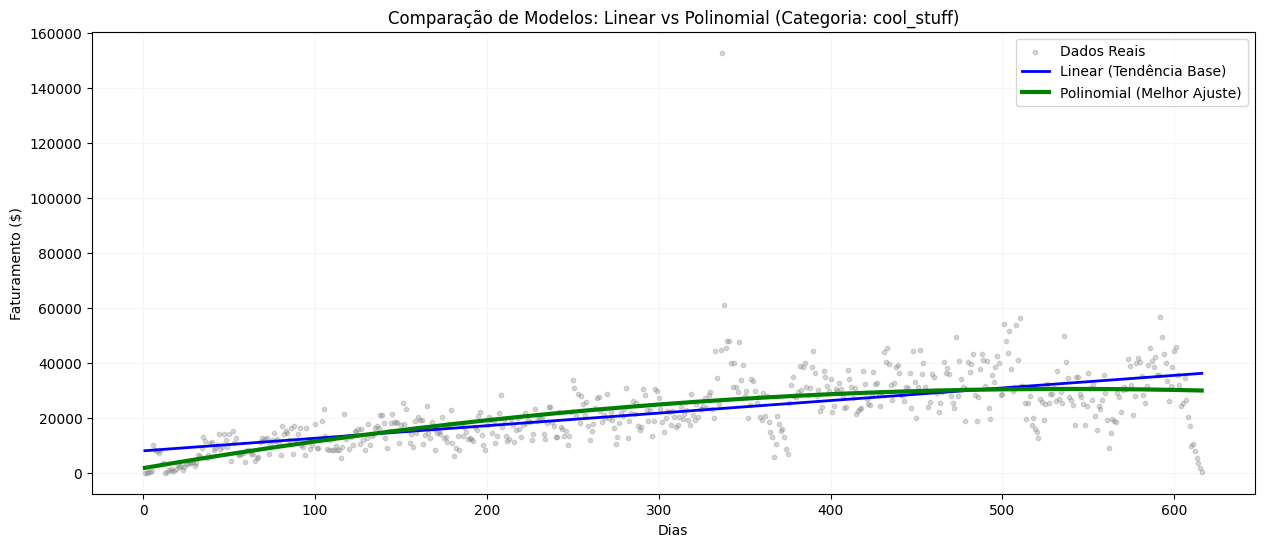

In [39]:
plt.figure(figsize=(15, 6))

# 1. Dados Reais
plt.scatter(days, sales, color='gray', alpha=0.3, label='Dados Reais', s=10)

# 2. Linha da Regressão Linear (R²: 0.42)
plt.plot(days, linear_pred, color='blue', label='Linear (Tendência Base)', linewidth=2)

# 3. Curva da Regressão Polinomial (R²: 0.47)
# Note que usamos 'poly_pred' que você acabou de calcular
plt.plot(days, poly_pred, color='green', label='Polinomial (Melhor Ajuste)', linewidth=3)

plt.title('Comparação de Modelos: Linear vs Polinomial (Categoria: cool_stuff)')
plt.xlabel('Dias')
plt.ylabel('Faturamento ($)')
plt.legend()
plt.grid(True, alpha=0.1)
plt.show()

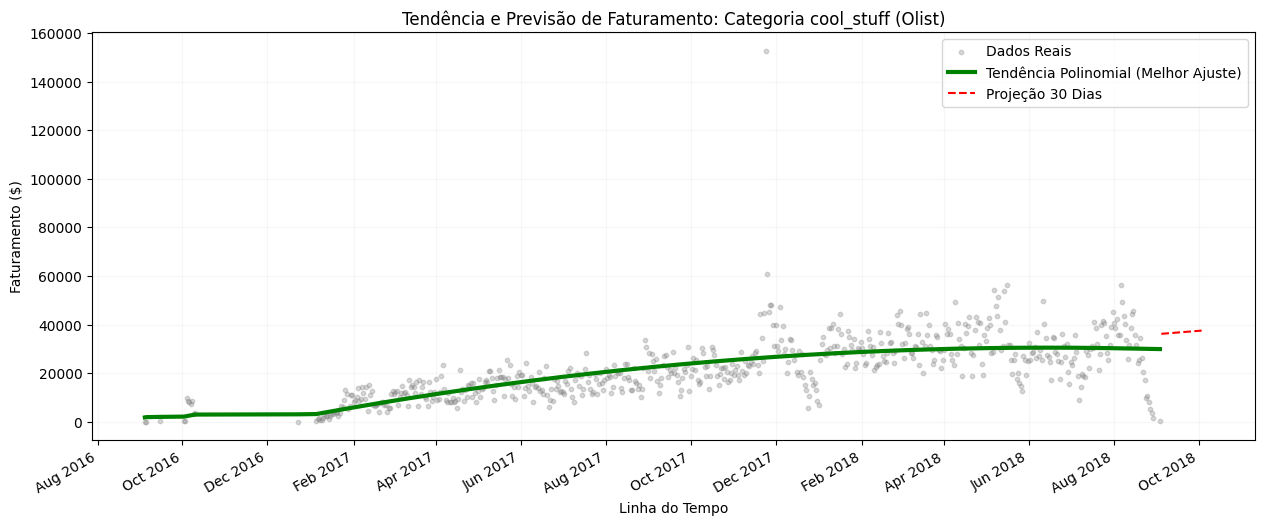

In [42]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))

# 1. Pegamos as datas reais para o eixo X
datas_reais = df_sales_day['date_only']
# Criamos datas futuras para a projeção (30 dias após a última data real)
datas_futuras = pd.date_range(start=datas_reais.iloc[-1] + pd.Timedelta(days=1), periods=30)

# 2. Plotamos os dados usando as DATAS no eixo X
plt.scatter(datas_reais, sales, color='gray', alpha=0.3, label='Dados Reais', s=10)
plt.plot(datas_reais, poly_pred, color='green', label='Tendência Polinomial (Melhor Ajuste)', linewidth=3)

# 3. Plotamos a projeção futura
plt.plot(datas_futuras, previsao_futura, color='red', linestyle='--', label='Projeção 30 Dias')

# --- FORMATAÇÃO DO EIXO DE DATA ---
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # Ex: Jan 2018
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # Mostra a cada 2 meses
plt.gcf().autofmt_xdate() # Inclina as datas para não sobrepor

plt.title('Tendência e Previsão de Faturamento: Categoria cool_stuff (Olist)')
plt.xlabel('Linha do Tempo')
plt.ylabel('Faturamento ($)')
plt.legend()
plt.grid(True, alpha=0.1)
plt.savefig('previsao_vendas_olist.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
#RESUMO

#A análise de regressão para a categoria cool_stuff revelou uma tendência de crescimento consistente ao longo de dois anos. 
#O modelo Polinomial de 2º grau apresentou um desempenho superior à Regressão Linear, elevando o coeficiente de determinação ($R^2$) de 0.42 para 0.47.
#Essa melhoria deve-se à capacidade do modelo de capturar a aceleração das vendas a partir de 2017 e a estabilização observada em 2018. 
#Embora o modelo sofra influência de picos sazonais extremos (como a Black Friday em Nov/2017), ele se mostra uma ferramenta robusta para o planejamento
#estratégico de longo prazo e previsão de faturamento base.